# Uterine fibroids follow-up treatment meta-analysis

Our goal is to estimate the probabilities of requiring one of a suite of candidate follow-up treatments following randomization to a given initial treatment for uterine fibroids. Specifically, we are interested in estimating:

$$Pr(I_2|I_1 =i,T=t)$$

where $I_1$ is an initial intervention, which take specific values $i = 1, 2, \ldots , K$ for each of $K$ candidate intervention types, $I_2$ is the followup intervention that also may take any of the same values of $i$, and $T$ is followup time in months, which will generally be either 6 or 12 months.

Our current set of candidate interventions include:

- Myomectomy
- Hysterectomy
- Ablation
- UAE
- Magnetic resonance imaging-guided high-intensity focused ultrasound (MRIgFUS) 
- Ablation +/- hysteroscopic myomectomy
- No intervention

Rather than model each conditional probability independently, we will instead model the outcomes for a treatment arm as a multinomial random variable. That is,

$$\{X_{I_2} \} ∼ \text{Multinomial}(N_{I_1}=i, \{\pi_i\})$$

where $\{X_{I_2}\}$ is the vector of outcomes corresponding to each of the possible followup interventions listed above, $N_{I_1}=i$ is the number of women randomized to the initial intervention i, and $\{\pi_i\}$ is a vector of conditional transition probabilities corresponding to $Pr(I_2|I_1 = i, T = t)$, as specified above. The multinomial distribution is a multivariate generalization of the categorical distribution, which is what the above simplifies to when modeling the outcome for a single patient. The multivariate formulation allows us to model study-arm-specific outcomes, incorporating covariates that are specific to that arm or study.
       
The quantities of interest are the vectors of transition probabilities $\{\pi_i\}$ corresponding to each of the initial candidate interventions. A naive approach to modeling these is to assign a vague Dirichlet prior distribution to each set, and perform Bayesian inference using the multinomial likelihood, with which the Dirichlet is conjugate, to yield posterior estimates for each probability. However, there may be additional information with which to model these probabilities, which may include:

- followup time for each study
- arm-specific demographic covariates (e.g. race, mean age) 
- study-specific random effects

hence, a given transition probability $\pi_{ijk}$ – the probability of transitioning from initial intervention $i$ to followup intervention $j$ in study $k$ – may be modeled as:

$$\text{logit}(\pi_{ijk})= \theta_{ij} + X_k \beta_{ij} + \epsilon_k$$

where $\theta_{ij}$ is a baseline transition probability (on the logit scale), $X_k$ a matrix of study(-arm)-specific covariates, $\beta_{ij}$ the corresponding coefficients, and $\epsilon_k$ a mean-zero random effect for study k. We will initially consider (1) follow-up time and (2) mean/median age as covariates.
 
An attractive benefit to using Bayesian inference to estimate this model is that it is easy to generate predictions from the model, via the posterior predictive distribution. For example, we could estimate the distribution of the expected proportion of women requiring a particular followup intervention; this estimate would factor in both the residual uncertainty in the transition probability estimates, as well as the sampling uncertainty of the intervention.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
sns.set()

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Import data from worksheets in Excel spreadsheet.

In [2]:
data_file = 'UF Subsequent Interventions Data_Master.xlsx'

missing = ['NA', 'NR', 'ND', '?', 'null']

occlusion_data = pd.read_excel('data/' + data_file, sheetname='OCC SP', na_values=missing)
occlusion_data = occlusion_data[~occlusion_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = occlusion_data.shape
print('Occlusion rows={0}, columns={1}, missing={2}'.format(rows, cols,
                                                        occlusion_data.isnull().sum().sum()))

# surgical_data = pd.read_excel('data/' + data_file, sheetname='Surgical (JA)', na_values=missing)
# surgical_data = surgical_data[~surgical_data['trial_arm'].isnull()].drop('notes', axis=1)
# print('Surgical rows={0}, columns={1}, missing={2}'.format(*surgical_data.shape, 
#                                                             surgical_data.isnull().sum().sum()))

med_vs_iac_data = pd.read_excel('data/' + data_file, sheetname='Med vs IAC JW', na_values=missing)
med_vs_iac_data = med_vs_iac_data[~med_vs_iac_data['trial_arm'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_iac_data.shape
print('Med vs IAC rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_iac_data.isnull().sum().sum()))

med_vs_med_data = pd.read_excel('data/' + data_file, sheetname='Med vs Med DVE', na_values=missing)
med_vs_med_data = med_vs_med_data[~med_vs_med_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_med_data.shape
print('Med vs Med rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_med_data.isnull().sum().sum()))

uae_data = pd.read_excel('data/' + data_file, sheetname='UAE SK')
uae_data = uae_data[~uae_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = uae_data.shape
print('UAE rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            uae_data.isnull().sum().sum()))

datasets = [occlusion_data, med_vs_iac_data, med_vs_med_data, uae_data]

Occlusion rows=6, columns=13, missing=0
Med vs IAC rows=49, columns=13, missing=46
Med vs Med rows=67, columns=13, missing=13
UAE rows=32, columns=13, missing=0


In [3]:
unique_inerventions = set(np.concatenate([d.intervention.values for d in datasets]))

Use the following lookup table to create "intervention category" field in each dataset.

In [4]:
intervention_lookup = {'Ablation': 'ablation',
 'Ablation+/- hysteroscopic myomectomy': 'ablation',
 'Asoprisnil 10 mg': 'med_manage',
 'Asoprisnil 25 mg': 'med_manage',
 'Asoprisnil 5 mg': 'med_manage',
 'CD20 (Ulipristal)': 'med_manage',
 'CDB10 (Ulipristal)': 'med_manage',
 'Hysterectomy': 'hysterectomy',
 'LBCUV': '',
 'LP + GnRH agonist plus raloxifene': 'med_manage',
 'LP + placebo': 'med_manage',
 'LPA+ MPA / LPA+placebo': 'med_manage',
 'LPA+ placebo / LPA+MPA': 'med_manage',
 'LUNA plus LBCUV': 'ablation',
 'Myomectomy': 'myomectomy',
 'No treatment': 'control',
 'No treatment (control)': 'control',
 'Placebo': 'control',
 'Raloxifene, 180mg/day': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (3 months) then tibolone 2.5 mg daily (3 months)': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (6 months)': 'med_manage',
 'SC implant of 3.6 goserelin + tibolone 2.5 mg daily (6 months)': 'med_manage',
 'Surgery': '',
 'Tibolone': 'med_manage',
 'UAE': 'uae',
 'UAE only': 'uae',
 'UAE plus goserelin acetate depot': 'uae',
 'buserelin + goserelin': 'med_manage',
 'buserelin, intranasal': 'med_manage',
 'cabergoline': 'med_manage',
 'diphereline': 'med_manage',
 'gestrinone, 2.5mg': 'med_manage',
 'gestrinone, 2.5mg oral + gestrinone, 5mg oral + gestrinone, 5mg vaginal': 'med_manage',
 'gestrinone, 5mg': 'med_manage',
 'gestrinone, 5mg vaginal': 'med_manage',
 'goserelin, subcutaneous': 'med_manage',
 'healthy controls': 'control',
 'hormone replacement therapy, transdermal': '',
 'hysterectomy or myomectomy': '',
 'letrozole, 2.5mg': 'med_manage',
 'leuprolide': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + Placebo': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + tibolone 2.5 mg/d orally': 'med_manage',
 'leuprolide acetate depot (3.75 mg/28 d) + placebo (B)': 'med_manage',
 'leuprolide plus (tibolone 2.5 mg daily) (A)': 'med_manage',
 'leuprolide plus MPA': 'med_manage',
 'leuprolide plus estrogen-progestin': 'med_manage',
 'leuprolide plus placebo': 'med_manage',
 'leuprolide plus progestin': 'med_manage',
 'leuprolide plus raloxifene 60 mg daily': 'med_manage',
 'leuprolide, 1.88mg': 'med_manage',
 'leuprolide, 3.75mg': 'med_manage',
 'mifepristone, 10mg': 'med_manage',
 'mifepristone, 10mg + mifepristone, 5mg': 'med_manage',
 'mifepristone, 2.5mg': 'med_manage',
 'mifepristone, 5mg': 'med_manage',
 'placebo': 'control',
 'raloxifene 180 mg daily': 'med_manage',
 'raloxifene 60 mg daily': 'med_manage',
 'tamoxifen 20 mg daily': 'med_manage',
 'tibolone': 'med_manage',
 'tibolone, 2.5mg': 'med_manage',
 'transdermal estrogen replacement therapy': 'med_manage',
 'triptorelin, 100ug': 'med_manage',
 'triptorelin, 100ug + triptorelin, 20ug + triptorelin, 5ug': 'med_manage',
 'triptorelin, 20ug': 'med_manage',
 'triptorelin, 3.6mg/mo': 'med_manage',
 'triptorelin, 5ug': 'med_manage',
 'ulipristal acetate followed by placebo': 'med_manage',
 'ulipristal acetate followed by progestin': 'med_manage',
 'ulipristal, 10mg': 'med_manage',
 'ulipristal, 5mg': 'med_manage'}

Assign intervention **categories** to each arm

In [5]:
datasets = [d.assign(intervention_cat=d.intervention.replace(intervention_lookup)) for d in datasets]

In [6]:
intervention_categories = set(intervention_lookup.values())
intervention_categories

{'', 'ablation', 'control', 'hysterectomy', 'med_manage', 'myomectomy', 'uae'}

Import demographic information

In [7]:
demographics = pd.read_excel('data/' + data_file, sheetname='ALL_DEMO_DATA', na_values=missing)
demographics.columns

Index(['study_id', 'Citation', 'FamCode', 'FamDesig', 'NCT', 'ArmsN',
       'ArmCategory', 'Group_Desc', 'New Grouping', 'Demo_Category',
       'Demo_specify', 'BL N', 'Denom_N', 'BL %', 'BL Mean', 'BL SD', 'BL_SE',
       'BL_Median', 'BL Min', 'BL Max', 'BL 95% L', 'BL 95% H',
       'BL_group_diff', 'Comments'],
      dtype='object')

Extract columns of interest

In [8]:
age_data = demographics.loc[demographics.Demo_Category=='Age', ['study_id', 'New Grouping', 'BL Mean', 'BL SD']]

Clean arm labels

In [9]:
age_data = age_data.assign(arm=age_data['New Grouping'].str.replace(':','')).drop('New Grouping', axis=1)

In [10]:
age_data.arm.unique()

array(['G2', 'G1', 'G1b', 'G1a', 'G3', 'CG', 'G1c', 'G1+G2', 'G1a+G1b+G1c'], dtype=object)

Concatenate all datasets

In [11]:
all_data = pd.concat(datasets)

Clean up study arm field

In [12]:
all_arm = all_data.trial_arm.str.replace(':','').str.replace(' ', '').str.replace('Group', 'G')
all_data = all_data.assign(arm=all_arm).drop('trial_arm', axis=1)

In [13]:
all_data.arm.unique()

array(['G1', 'G2', 'CG', 'G1a', 'G1b', 'G1c', 'CG1', 'CG2', 'G1/CG',
       'CG/G1', 'G1a+G1b', 'G1a+G1b+G1c', 'G1+G2'], dtype=object)

Clean up study ID field. Currently contains non-numeric entries. Will strip out the first study ID from the compund labels, as this is the parent study ID.

In [14]:
all_data.study_id.unique()

array([5186, 414, 1849, 3016, 3181, 3324, 3674, 4258, 4468, 4858, 4960,
       5276, 5302, 6091, 6263, 6696, 7155, 7504, 7797, 7936, 95.0, 629.0,
       757.0, 1290.0, 2318.0, 2555.0, 2635.0, 3312.0, 3978.0, 4787.0,
       4961.0, 5721.0, 6393.0, 6903.0, 7139.0, 7309.0, 7530.0, 7589.0,
       7763.0, '3803_3052', 1546, '3365_2026_1657_986', 1400,
       '3819_815_1986_2759_2971_\n3120_3175_3192_3678_3721', 4789, 2006], dtype=object)

In [15]:
str_mask = all_data.study_id.str.isnumeric()==False
all_data.loc[str_mask, 'study_id'] = all_data.study_id[str_mask].apply(lambda x: x[:x.find('_')])
all_data.study_id = all_data.study_id.astype(int)

Here is what the data look like after merging.

In [16]:
all_data.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm
0,5186,LUNA plus LBCUV,40,1,38,0,0,0,0,0,0,38,ablation,G1
1,5186,LBCUV,43,1,42,0,0,0,0,0,0,42,,G2
2,5186,LUNA plus LBCUV,40,3,38,0,0,0,0,0,0,38,ablation,G1
3,5186,LBCUV,43,3,42,0,0,0,0,0,0,42,,G2
4,5186,LUNA plus LBCUV,40,6,38,0,0,0,0,0,0,38,ablation,G1


In [17]:
all_data.groupby('intervention_cat')['study_id'].count()

intervention_cat
                 10
ablation          3
control          11
hysterectomy      7
med_manage      100
myomectomy        5
uae              18
Name: study_id, dtype: int64

Merge age data with outcomes

In [18]:
all_data_merged = pd.merge(all_data, age_data, on=['study_id', 'arm'])

For now, drop arms with no reported followup time (we may want to impute these):

In [19]:
all_data_merged = all_data_merged.dropna(subset=['followup_interval'])

Parse followup intervals that are ranges, creating `fup_min` and `fup_max` fields.

In [20]:
dataset = all_data_merged.assign(fup_min=0, fup_max=all_data.followup_interval.convert_objects(convert_numeric=True).max()+1)
range_index = dataset.followup_interval.str.contains('to').notnull()
range_vals = dataset[range_index].followup_interval.apply(lambda x: x.split(' '))
dataset.loc[range_index, ['fup_min']] = range_vals.apply(lambda x: float(x[0]))
dataset.loc[range_index, ['fup_max']] = range_vals.apply(lambda x: float(x[-1]))
dataset.loc[range_index, ['followup_interval']] = -999
dataset['followup_interval'] = dataset.followup_interval.astype(float)

In [21]:
dataset.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm,BL Mean,BL SD,fup_max,fup_min
0,5186,LUNA plus LBCUV,40,1,38,0,0,0,0,0,0,38,ablation,G1,44.5,4.4,61,0
1,5186,LUNA plus LBCUV,40,3,38,0,0,0,0,0,0,38,ablation,G1,44.5,4.4,61,0
2,5186,LUNA plus LBCUV,40,6,38,0,0,0,0,0,0,38,ablation,G1,44.5,4.4,61,0
3,5186,LBCUV,43,1,42,0,0,0,0,0,0,42,,G2,43.1,5.1,61,0
4,5186,LBCUV,43,3,42,0,0,0,0,0,0,42,,G2,43.1,5.1,61,0


Fill missing values

In [22]:
dataset.loc[dataset.followup_n.isnull(), 'followup_n'] = dataset.loc[dataset.followup_n.isnull(), 'baseline_n']

In [23]:
dataset.loc[dataset.no_treatment.isnull(), 'no_treatment'] = dataset.followup_n - dataset[[ 'hysterectomy', 'myomectomy', 'uae',
                                                        'MRIgFUS', 'ablation', 'iud']].sum(1)[dataset.no_treatment.isnull()]

In [24]:
dataset.followup_interval.unique()

array([   1. ,    3. ,    6. ,   12. ,    5.5,    9. ,   18. ,    0. ,
          2. , -999. ,   24. ,    7. ,   60. ])

In [25]:
crossover_studies = 7155, 3324, 414, 95, 7139, 6903, 3721, 3181, 4858, 4960, 4258, 4789, 2006, 2318

In [26]:
uae_data = dataset[dataset.intervention_cat=='uae']

In [27]:
uae_data.columns

Index(['study_id', 'intervention', 'baseline_n', 'followup_interval',
       'followup_n', 'hysterectomy', 'myomectomy', 'uae', 'MRIgFUS',
       'ablation', 'iud', 'no_treatment', 'intervention_cat', 'arm', 'BL Mean',
       'BL SD', 'fup_max', 'fup_min'],
      dtype='object')

In [28]:
studies = uae_data.study_id.unique()
studies

array([3674, 3803, 1546, 3365, 1400, 3819, 4789, 2006])

In [29]:
study_index = np.array([np.argwhere(studies==i).squeeze() for i in uae_data.study_id])

In [30]:
from numpy.ma import masked_values

followup_masked = masked_values(uae_data.followup_interval.values, -999)
followup_min, followup_max = uae_data[['fup_min', 'fup_max']].values.T

outcomes = uae_data[[ 'hysterectomy', 'myomectomy', 'uae',
       'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values

followup_n = uae_data.followup_n.values

age = uae_data['BL Mean'].values
# Center age at 40
age_centered = age - 40

study_id = uae_data.study_id.values

In [31]:
n_studies = len(set(study_id))
n_studies

8

In [32]:
n_outcomes = 7
arms = len(outcomes)

In [38]:
import theano.tensor as T

SumTo1 = pm.transforms.SumTo1()
inverse_logit = pm.transforms.inverse_logit

with pm.Model() as model:
    
    # Impute followup times
    followup_time = pm.Uniform('followup_time', followup_min, followup_max, 
                               shape=len(followup_min), 
                               observed=followup_masked)
    
    # Mean probabilities (on logit scale)
    μ = pm.Normal('μ', 0, 0.01, shape=n_outcomes, testval=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 3])
    # Followup time covariates 
    β_fup = pm.Normal('β_fup', 0, 0.01, shape=n_outcomes, testval=np.zeros(n_outcomes))
    # Age covariate
    β_age = pm.Normal('β_age', 0, 0.01, shape=n_outcomes, testval=np.zeros(n_outcomes))
    
    # Study random effect
    τ = pm.Exponential('τ', 0.1, testval=1)
    ϵ = pm.Normal('ϵ', 0, τ, shape=n_studies, testval=np.zeros(n_studies))
    
    # Expected value (on logit scale)
    θ_uae = [T.exp(μ + β_fup*followup_time[i] + β_age*age_centered[i] + ϵ[study_index[i]]) 
                     for i in range(arms)]
    
    # Inverse-logit transformation to convert to probabilities
    p_uae = [pm.Dirichlet('p_uae_%i' % i, θ, shape=n_outcomes) for i,θ in enumerate(θ_uae)]
    
    # Multinomial data likelihood
    likelihood = [pm.Multinomial('likelihood_%i' % i, followup_n[i], p_uae[i], 
                                 observed=outcomes[i]) for i in range(arms)]
    
    p_6 = pm.Dirichlet('p_6', T.exp(μ + β_fup*6), shape=n_outcomes)
    p_12 = pm.Dirichlet('p_12', T.exp(μ + β_fup*12), shape=n_outcomes)
    p_6_50 = pm.Dirichlet('p_6_50', T.exp(μ + β_fup*6 + β_age*10), shape=n_outcomes)

Applied log-transform to τ and added transformed τ_log to model.
Applied stickbreaking-transform to p_uae_0 and added transformed p_uae_0_stickbreaking to model.
Applied stickbreaking-transform to p_uae_1 and added transformed p_uae_1_stickbreaking to model.
Applied stickbreaking-transform to p_uae_2 and added transformed p_uae_2_stickbreaking to model.
Applied stickbreaking-transform to p_uae_3 and added transformed p_uae_3_stickbreaking to model.
Applied stickbreaking-transform to p_uae_4 and added transformed p_uae_4_stickbreaking to model.
Applied stickbreaking-transform to p_uae_5 and added transformed p_uae_5_stickbreaking to model.
Applied stickbreaking-transform to p_uae_6 and added transformed p_uae_6_stickbreaking to model.
Applied stickbreaking-transform to p_uae_7 and added transformed p_uae_7_stickbreaking to model.
Applied stickbreaking-transform to p_uae_8 and added transformed p_uae_8_stickbreaking to model.
Applied stickbreaking-transform to p_uae_9 and added transform

In [ ]:
with model:
    
    if False:
        start = pm.find_MAP()
        step = NUTS(scaling=start)
        trace_uae = pm.sample(5000, step=step, start=start)
        
    else:
        trace_uae = pm.sample(20000, step=pm.Metropolis())

### Model output

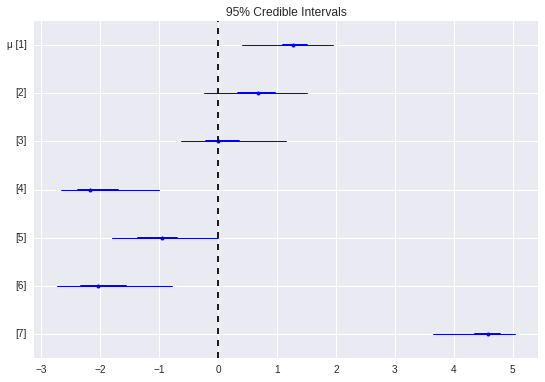

In [44]:
pm.forestplot(trace_uae, vars=['μ'])

Follow-up time effect size estimates. Positive values indicate higher probability of event with increased follow-up time.

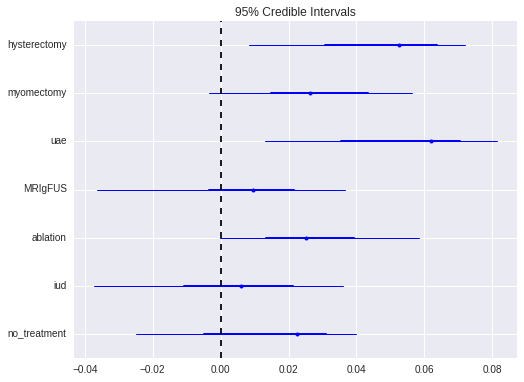

In [54]:
pm.forestplot(trace_uae, vars=['β_fup'], ylabels=plot_labels)

Age effect size estimates. Positive values suggest higher probability of event with each year above age 40.

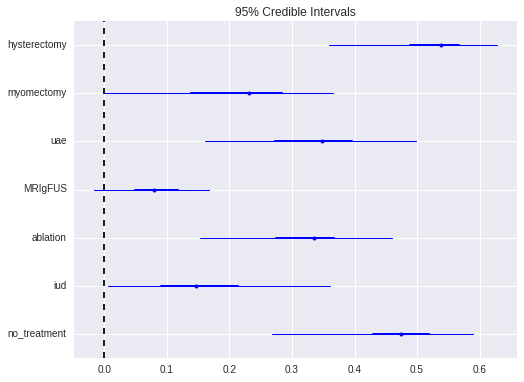

In [55]:
pm.forestplot(trace_uae, vars=['β_age'], ylabels=plot_labels)

Estimated probabilities of follow-up interventions for 6-month followup and age 40.

In [50]:
plot_labels = dataset.columns[5:12]

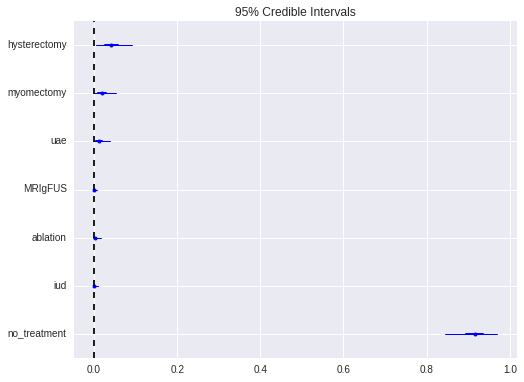

In [51]:
pm.forestplot(trace_uae, vars=['p_6'], ylabels=plot_labels)

In [58]:
pm.summary(trace_uae, vars=['p_6'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.044            0.023            0.001            [0.005, 0.092]
  0.022            0.017            0.001            [0.000, 0.053]
  0.014            0.014            0.001            [0.000, 0.039]
  0.001            0.006            0.000            [0.000, 0.007]
  0.005            0.009            0.000            [0.000, 0.018]
  0.002            0.006            0.000            [0.000, 0.009]
  0.912            0.035            0.002            [0.844, 0.970]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.009          0.027          0.041          0.057          0.100
  0.001          0.010          0.018          0.030          0.063
  0.000          0.005          0.011          0.020          0.046
  0.000     

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

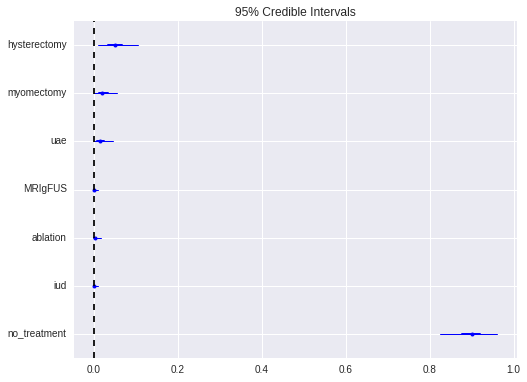

In [52]:
pm.forestplot(trace_uae, vars=['p_12'], ylabels=plot_labels)

In [57]:
pm.summary(trace_uae, vars=['p_12'])


p_12:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.053            0.026            0.001            [0.009, 0.106]
  0.024            0.017            0.001            [0.000, 0.055]
  0.018            0.014            0.001            [0.000, 0.046]
  0.002            0.007            0.000            [0.000, 0.009]
  0.005            0.008            0.000            [0.000, 0.017]
  0.002            0.007            0.000            [0.000, 0.009]
  0.896            0.037            0.002            [0.824, 0.961]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.013          0.034          0.050          0.068          0.113
  0.002          0.011          0.020          0.032          0.066
  0.001          0.008          0.015          0.025          0.054
  0.000    

Estimated probabilities of follow-up interventions for 12-month followup and age 50.

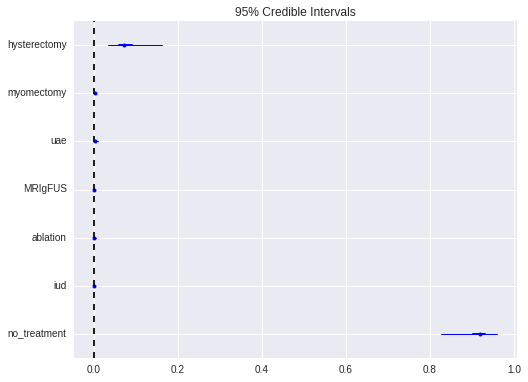

In [53]:
pm.forestplot(trace_uae, vars=['p_6_50'], ylabels=plot_labels)

In [56]:
pm.summary(trace_uae, vars=['p_6_50'])


p_6_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.080            0.033            0.003            [0.032, 0.163]
  0.002            0.004            0.000            [0.000, 0.004]
  0.005            0.006            0.000            [0.001, 0.010]
  0.001            0.007            0.000            [0.000, 0.000]
  0.002            0.005            0.000            [0.000, 0.004]
  0.001            0.006            0.000            [0.000, 0.000]
  0.910            0.037            0.004            [0.827, 0.960]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.034          0.061          0.072          0.090          0.165
  0.000          0.001          0.002          0.002          0.006
  0.001          0.002          0.004          0.006          0.011
  0.000  